In [1]:
import torch
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel
from setfit import SetFitTrainer
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from transformers import pipeline
from datasets import load_dataset
from transformers.pipelines.pt_utils import KeyDataset
import sklearn.metrics

/Users/jchang15/anaconda3/envs/defects/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
df = pd.read_csv('./data_unlabeled/all_unlabeled.csv')
labeled_df = pd.read_csv('./data_labeled/all_labeled.csv')

unlabeled_set = Dataset.from_pandas(df)
labeled_test_set = Dataset.from_pandas(labeled_df)

In [4]:
# bug = labeled_df.loc[labeled_df['label'] == 0]
# docs = labeled_df.loc[labeled_df['label'] == 1].sample(50)
# feature = labeled_df.loc[labeled_df['label'] == 2].sample(50)
# question = labeled_df.loc[labeled_df['label'] == 3].sample(50)

bug_train, bug_test = train_test_split(labeled_df.loc[labeled_df['label'] == 0], random_state=seed, train_size=50, test_size=50)
docs_train, docs_test = train_test_split(labeled_df.loc[labeled_df['label'] == 1], random_state=seed, train_size=50, test_size=50)
feature_train, feature_test = train_test_split(labeled_df.loc[labeled_df['label'] == 2], random_state=seed, train_size=50, test_size=50)
question_train, question_test = train_test_split(labeled_df.loc[labeled_df['label'] == 3], random_state=seed, train_size=50)

train_df = pd.concat([bug_train, docs_train, feature_train, question_train], ignore_index=True)
test_df = pd.concat([bug_test, docs_test, feature_test, question_test], ignore_index=True)

train_set = Dataset.from_pandas(train_df)
test_set = Dataset.from_pandas(test_df)

## SETFIT Baseline Model from https://github.com/collab-uniba/Few-Shot-Learning-for-Issue-Report-Classification 

In [5]:
model = SetFitModel.from_pretrained("PeppoCola/FewShotIssueClassifier-NLBSE23")

/Users/jchang15/anaconda3/envs/defects/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
y_pred = model.predict(test_set['text'])

print(classification_report(test_set['label'], y_pred, digits=4))
print(confusion_matrix(test_set['label'], y_pred))

              precision    recall  f1-score   support

         0.0     0.5116    0.4400    0.4731        50
         1.0     0.6136    0.5400    0.5745        50
         2.0     0.4118    0.5600    0.4746        50
         3.0     0.6667    0.5517    0.6038        29

    accuracy                         0.5196       179
   macro avg     0.5509    0.5229    0.5315       179
weighted avg     0.5373    0.5196    0.5230       179

[[22  6 19  3]
 [ 3 27 18  2]
 [ 9 10 28  3]
 [ 9  1  3 16]]


## Fine-tuned RoBERTa Baseline Model from https://github.com/nlbse2023/issue-report-classification  

In [7]:
classifier = pipeline(model="rafaelkallis/tickettagger-roberta", max_length=224, truncation=True, batch_size=256)

In [8]:
dataset = test_set

y_true = dataset["label"]
id2label = {0: "bug", 1: "documentation", 2: "feature", 3: "question"}
#id2label = {0: "bug", 1: "feature", 2: "question", 3: "documentation"}
y_true = [id2label[y] for y in y_true]

y_pred = list(tqdm(classifier(KeyDataset(dataset, "text")), total=len(y_true)))
y_pred = [p["label"] for p in y_pred]

for label in ["bug", "feature", "question", "documentation"]:
  P_c = sklearn.metrics.precision_score(y_true, y_pred, average=None, labels=[label])[0]
  R_c = sklearn.metrics.recall_score(y_true, y_pred, average=None, labels=[label])[0]
  F1_c = sklearn.metrics.f1_score(y_true, y_pred, average=None, labels=[label])[0]
  print(f"=*= {label} =*=")
  print(f"precision:\t{P_c:.4f}")
  print(f"recall:\t\t{R_c:.4f}")
  print(f"F1 score:\t{F1_c:.4f}")
  print()


P = sklearn.metrics.precision_score(y_true, y_pred, average='macro')
R = sklearn.metrics.recall_score(y_true, y_pred, average='micro')
F1 = sklearn.metrics.f1_score(y_true, y_pred, average='micro')

print("=*= micro averages =*=")
print(f"precision:\t{P:.4f}")
print(f"recall:\t\t{R:.4f}")
print(f"F1 score:\t{F1:.4f}")

100%|█████████████████████████████████████████| 179/179 [00:09<00:00, 19.38it/s]

=*= bug =*=
precision:	0.4706
recall:		0.8000
F1 score:	0.5926

=*= feature =*=
precision:	0.5870
recall:		0.5400
F1 score:	0.5625

=*= question =*=
precision:	0.9231
recall:		0.4138
F1 score:	0.5714

=*= documentation =*=
precision:	0.8857
recall:		0.6200
F1 score:	0.7294

=*= micro averages =*=
precision:	0.7166
recall:		0.6145
F1 score:	0.6145


## Train SETFIT Model from pre-labeled data 

In [9]:
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_set,
    eval_dataset=test_set,
    loss_class=CosineSimilarityLoss,
    num_iterations=20,
    num_epochs=1,
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [10]:
trainer.train()

Generating Training Pairs: 100%|███████████████| 20/20 [00:00<00:00, 170.45it/s]
***** Running training *****
  Num examples = 8000
  Num epochs = 1
  Total optimization steps = 500
  Total train batch size = 16
Iteration:  19%|█████▍                       | 93/500 [26:45<1:57:53, 17.38s/it]


Iteration:  38%|██████████▋                 | 190/500 [56:08<1:31:03, 17.62s/it]


Iteration:  57%|████████████████            | 287/500 [1:24:26<59:38, 16.80s/it]


Iteration:  77%|█████████████████████▌      | 384/500 [2:05:09<40:01, 20.70s/it]


Iteration:  96%|██████████████████████████▉ | 481/500 [2:34:45<05:35, 17.65s/it]


Epoch: 100%|██████████████████████████████████| 1/1 [2:40:02<00:00, 9602.10s/it]


In [11]:
metrics = trainer.evaluate()
metrics

***** Running evaluation *****


{'accuracy': 0.7150837988826816}

In [12]:
trainer.model._save_pretrained('model')

In [13]:
model = SetFitModel.from_pretrained('model')

In [14]:
y_pred = model.predict(test_set['text'])

print(classification_report(test_set['label'], y_pred, digits=4))
print(confusion_matrix(test_set['label'], y_pred))

              precision    recall  f1-score   support

         0.0     0.6875    0.6600    0.6735        50
         1.0     0.8409    0.7400    0.7872        50
         2.0     0.5763    0.6800    0.6239        50
         3.0     0.8571    0.8276    0.8421        29

    accuracy                         0.7151       179
   macro avg     0.7405    0.7269    0.7317       179
weighted avg     0.7268    0.7151    0.7187       179

[[33  3 11  3]
 [ 1 37 12  0]
 [12  3 34  1]
 [ 2  1  2 24]]


## Classify All Unlabeled Data 

In [17]:
y_pred = model.predict(unlabeled_set['text'])

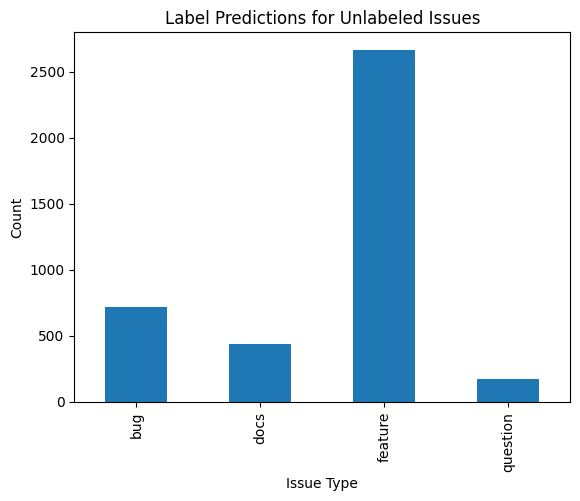

In [46]:
label_map = {
    0:'bug', 
    1:'docs',
    2:'feature',
    3:'question'
}

pred = pd.Categorical([label_map[x] for x in y_pred.numpy()])

#pred = pd.DataFrame(y_pred.numpy())

pred.value_counts().plot(kind='bar')
plt.title('Label Predictions for Unlabeled Issues')
plt.xlabel('Issue Type')
plt.ylabel('Count')
plt.show()

In [49]:
df['preds'] = pred

df.to_csv('preds.csv')